#### ARIMA, SARIMA, auto_arima

Box_Jenkins ARIMA Procedure
1. Data Processing
2. Identify Model to be Tentatively Entertained
3. Estimate Parameters
4. Diagnosis Check
5. User Model to Forecast

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


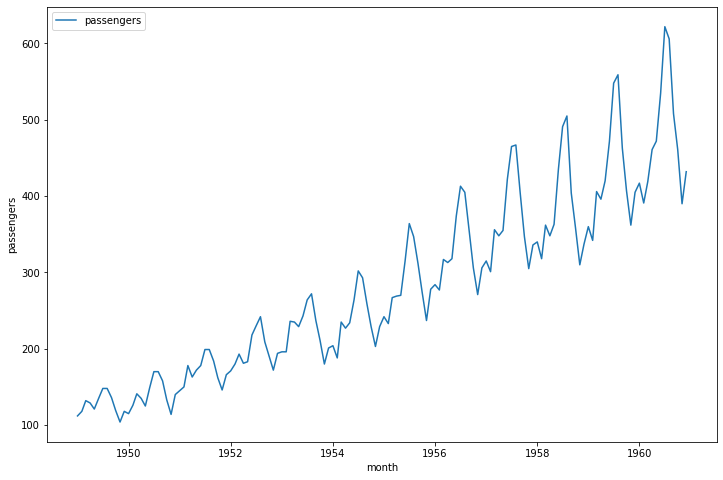

In [24]:
# Data Processing
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('./data/AirPassengers.csv')
df.rename(columns={'Month':'month', '#Passengers':'passengers'},
          inplace=True)
df['month'] = pd.to_datetime(df['month'])
df.set_index('month', inplace=True)

plt.xlabel('month')
plt.ylabel('passengers')
plt.plot(df, label='passengers')
plt.legend()
display(df)

In [25]:
for i in df['passengers']:
    if i ==0:
        print(i)

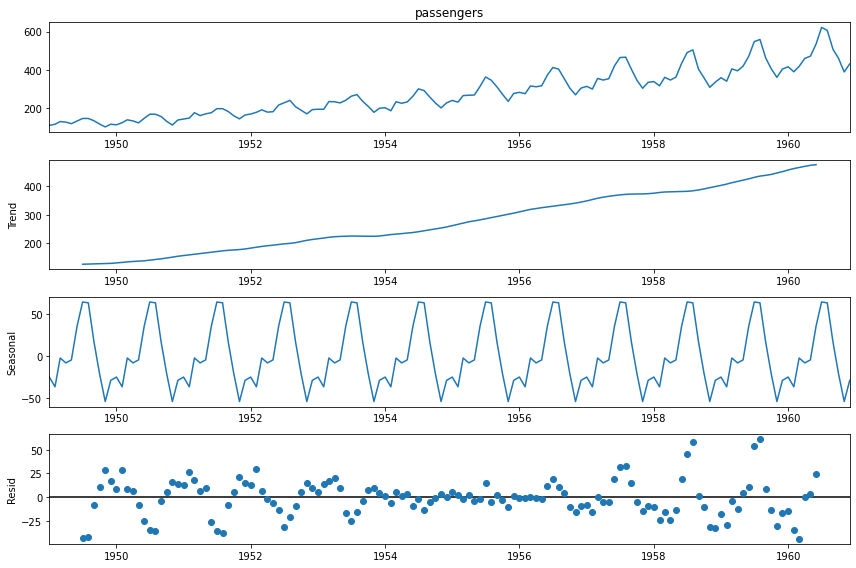

In [26]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['passengers'], model='additive')
plt.rcParams['figure.figsize'] = [12,8]
decomposition.plot()
plt.show()

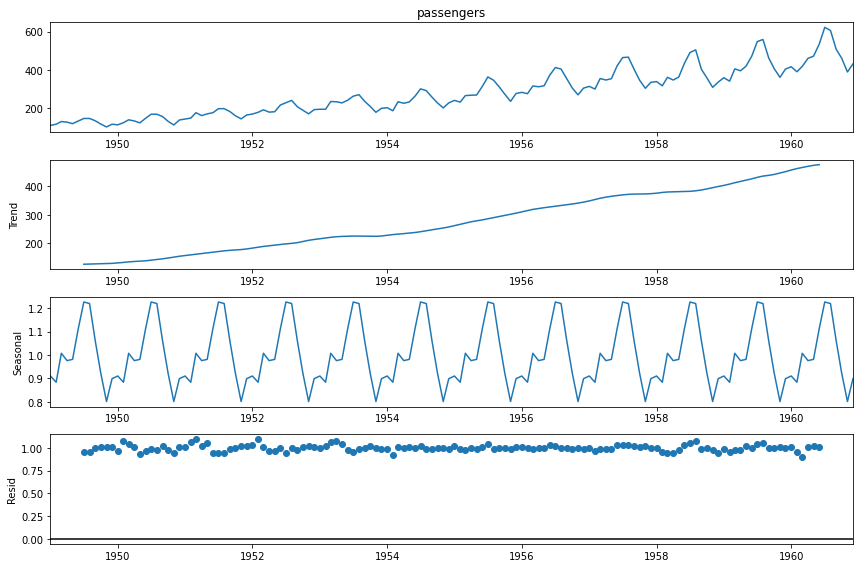

In [27]:
import statsmodels.api as sm

multi = sm.tsa.seasonal_decompose(df['passengers'], model='multicative')
plt.rcParams['figure.figsize'] = [12,8]
multi.plot()
plt.show()

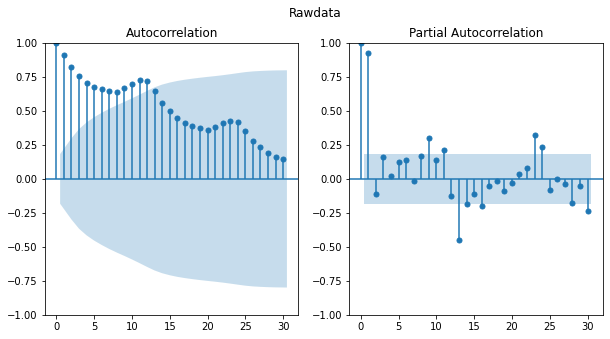

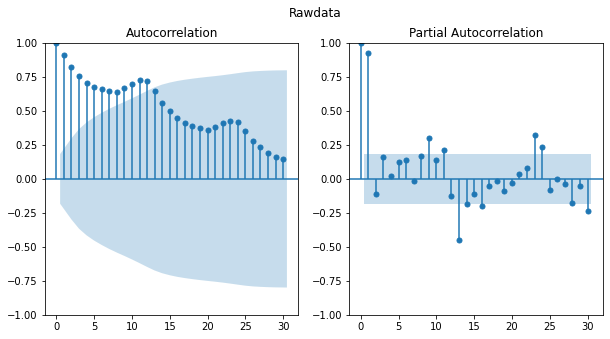

In [28]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Rawdata')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

In [29]:
# 정상성 테스트
from statsmodels.tsa.stattools import adfuller

adf = adfuller(train_data, regression='ct')
print('ADF Statistic : {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic : -2.237128491655422
p-value : 0.4689881842993152


데이터가 정상성을 갖지 않는다고 판단

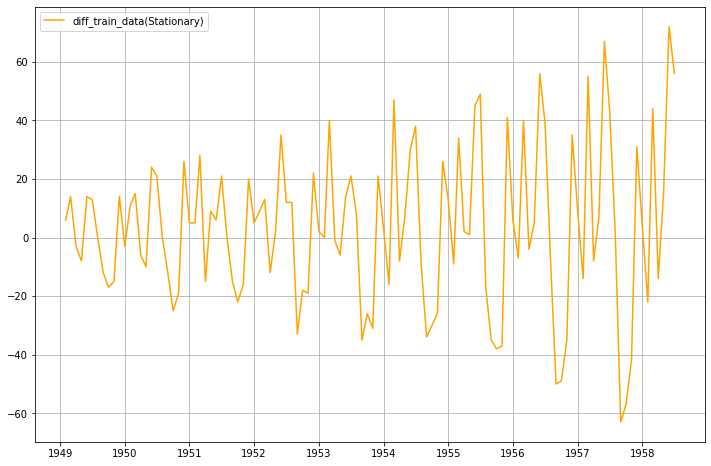

In [30]:
# 차분
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna()

plt.plot(diff_train_data, 'orange', label='diff_train_data(Stationary)')
plt.grid()
plt.legend()

In [31]:
adf = adfuller(diff_train_data)
print("ADF Statistic : {}".format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic : -2.5396347808080937
p-value : 0.10612609999673461


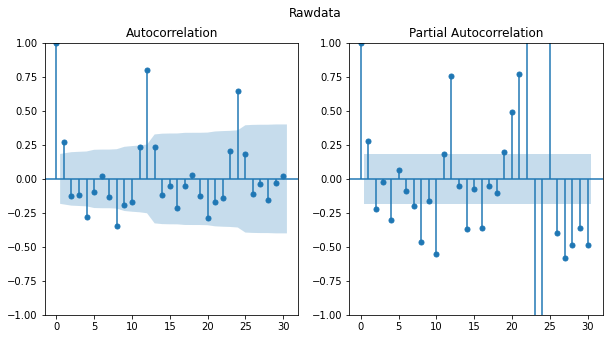

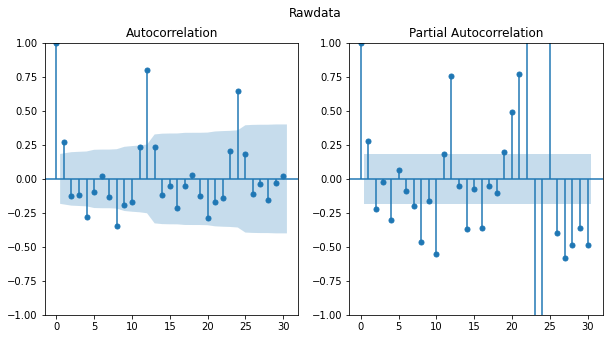

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Rawdata')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

In [33]:
import itertools
import warnings
warnings.filterwarnings('ignore')

p = range(0,3)
d = range(1,2)
q = range(0,3)

# 세가지의 배열의 값을 각각 조합하여 새로운 배열로 만들어 줌
pdq = list(itertools.product(p,d,q))
aic = []

for i in pdq:
    model = sm.tsa.ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print('ARIMA Order : {} -> AIC : {}'.format(i, model_fit.aic))
    aic_dict = {'order' : i, 'aic' : model_fit.aic}
    aic.append(aic_dict)
    
result_by_aic = pd.DataFrame(aic)
result_by_aic.sort_values(by='aic', ascending=True, inplace=True)
result_by_aic.reset_index(inplace=True)
result_by_aic

ARIMA Order : (0, 1, 0) -> AIC : 1076.2711877003119
ARIMA Order : (0, 1, 1) -> AIC : 1063.6457928455957
ARIMA Order : (0, 1, 2) -> AIC : 1060.6854981868717
ARIMA Order : (1, 1, 0) -> AIC : 1068.5358062697533
ARIMA Order : (1, 1, 1) -> AIC : 1058.2455736393413
ARIMA Order : (1, 1, 2) -> AIC : 1057.3275350108338
ARIMA Order : (2, 1, 0) -> AIC : 1065.6421539978012
ARIMA Order : (2, 1, 1) -> AIC : 1058.6476156756362
ARIMA Order : (2, 1, 2) -> AIC : 1057.5161781058678


,index,order,aic
0,5,"(1, 1, 2)",1057.327535
1,8,"(2, 1, 2)",1057.516178
2,4,"(1, 1, 1)",1058.245574
3,7,"(2, 1, 1)",1058.647616
4,2,"(0, 1, 2)",1060.685498
5,1,"(0, 1, 1)",1063.645793
6,6,"(2, 1, 0)",1065.642154
7,3,"(1, 1, 0)",1068.535806
8,0,"(0, 1, 0)",1076.271188


In [34]:
# aic가 가장 낮은 모델 select

model_opt = sm.tsa.ARIMA(train_data.values, order=result_by_aic.iloc[0,1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -524.664
Date:                Sun, 21 Aug 2022   AIC                           1057.328
Time:                        02:48:27   BIC                           1068.272
Sample:                             0   HQIC                          1061.769
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.128      4.219      0.000       0.288       0.789
ma.L1         -0.2053      0.122     -1.688      0.091      -0.444       0.033
ma.L2         -0.5606      0.084     -6.647      0.000      -0.726      -0.395
sigma2       578.5728    105.827      5.467      0.000     371.155     785.991
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):                 4.81
Prob(Q):                              0.47   Prob(JB):                         0.09
Heteroskedasticity (H):               5.54   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

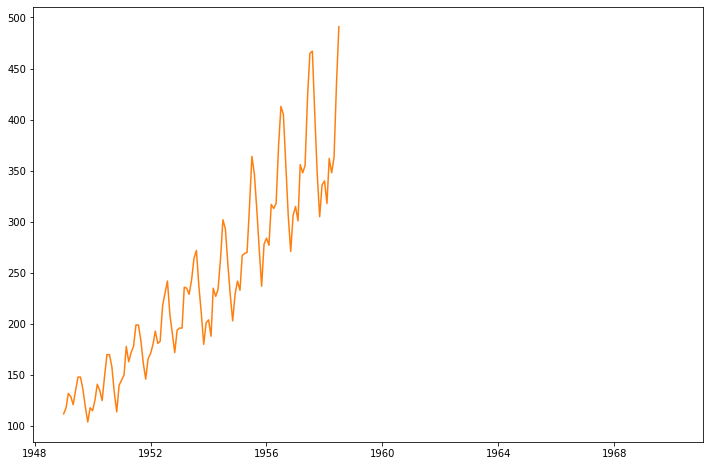

In [37]:
plt.plot(model_opt_fit.predict(len(train_data)))
plt.plot(train_data)

In [41]:
import datetime
import numpy as np
from sklearn.metrics import r2_score

prediction = model_opt_fit.predict(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

forecast_start_date = datetime.datetime(1958,8,1)
forecast_start_date = np.datetime64(forecast_start_date)

plt.figure(dpi=150)
plt.plot(df.index, df['passengers'], lable='passengers')
plt.vlines(forecast_start_date, 0, 1000, linestyle ='--', color='r', label='Forecast Start')
plt.plot(predict_index, predicted_value, label='Prediction')
plt.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, lable = '0.95 Prediction Interval')
plt.legend(loc='upper left')
plt.suptitle("ARIMA {} Predcition Results (r2_score : {4.2f})".format(result_by_aic.iloc[0,1],r2))

IndexError: invalid index to scalar variable.